import libraries

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark import SparkContext, SparkConf
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Loading dataset

In [ ]:
filepath = "/content/drive/MyDrive/CAS_with_claims_final.csv"
df = spark.read.csv(filepath, header= True, inferSchema = True)

Preprocessing

In [ ]:
col_to_drop = ['_c0', 'X', 'Y','OBJECTID' ,'crashRoadSideRoad','intersection','pedestrian','temporarySpeedLimit','advisorySpeed',
              'crashDirectionDescription', 'crashFinancialYear', 'crashLocation1', 'crashLocation2', 'crashSHDescription',
              'directionRoleDescription', 'flatHill', 'holiday', 'light', 'region',
              'roadCharacter', 'roadLane', 'roadSurface', 'streetLight', 'tlaName', 'meshblockId', 'areaUnitID', 'crashYear', 'tlaId',
              'trafficControl', 'crashSeverity' ]
df = df.drop(*col_to_drop)

df = df.na.drop()
cols_to_encode= ['weatherA', 'weatherB', 'urban']
# import the required libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

# numeric indexing for the strings (indexing starts from 0)
indexer = StringIndexer(inputCols= cols_to_encode, outputCols= ['weatherA_num', 'weatherB_num', 'urban_num'] ) 

# fit the indexer model and use it to transform the strings into numeric indices
indexed_df = indexer.fit(df).transform(df)

# one-hot-encoding the numeric indices
ohe = OneHotEncoder(inputCols= [ 'weatherA_num', 'weatherB_num', 'urban_num'], outputCols= ['weatherA_onehot', 'weatherB_onehot', 'urban_onehot'])

# fit the ohe model and use it to transform the numeric indices into ohe vectors
df1 = ohe.fit(indexed_df).transform(indexed_df)

df1= df1.drop(*cols_to_encode)
X = df1.drop('Claim_amount')

Vectorization to fit into model

In [ ]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler(inputCols = X.columns, outputCol = 'features')
v_df = vectorAssembler.transform(df1)
v_df = v_df.select(['features', 'Claim_amount'])
v_df1= v_df.withColumnRenamed('Claim_amount', 'label')
train, test= v_df1.randomSplit([0.7, 0.3])
train.show(5)

+--------------------+---------+
|            features|    label|
+--------------------+---------+
|(53,[0,1,3,12,15,...|3572792.0|
|(53,[0,1,12,15,27...|1188144.0|
|(53,[0,1,15,27,37...|      0.0|
|(53,[0,2,3,12,15,...| 825802.0|
|(53,[0,2,3,12,15,...| 610944.0|
+--------------------+---------+
only showing top 5 rows



In [ ]:
def evaluate(model):
  #Prediction
  pred= model.transform(test)
  pred= pred.withColumn('label', col('label').cast('double'))
  valuesAndPreds = pred.select(['label', 'prediction'])

  # It needs to convert to RDD as the parameter of RegressionMetrics
  valuesAndPreds = valuesAndPreds.rdd.map(tuple)

  #Evaluation
  metrics = RegressionMetrics(valuesAndPreds)
  # Squared Error
  print("MSE = %s" % metrics.meanSquaredError)
  print("RMSE = %s" % metrics.rootMeanSquaredError)
  # Mean absolute error
  print("MAE = %s" % metrics.meanAbsoluteError)
  # R squared 
  print("R2 = %s" % metrics.r2)
  # Explained variance
  print("Explained variance = %s" % metrics.explainedVariance)

  pred_pandas = pred.toPandas()

  plt.scatter('label', 'prediction', data = pred_pandas)
  plt.xlabel('Actual values')
  plt.ylabel('Predicted values')
  plt.show()

Tweedie GLM

In [ ]:
#Estimating Claims cost using Gamma Distribution
tweedie = GeneralizedLinearRegression(family="tweedie", labelCol="label",maxIter= 500)
t_model= tweedie.fit(train)

evaluate(t_model)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 333847453820.2811
RMSE = 577795.339043403
MAE = 304273.7537406553
R2 = 0.7466373208313465
Explained variance = 1592339054414.0586


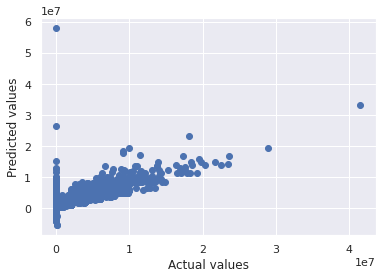

In [ ]:
evaluate(t_model)

In [ ]:
pred= t_model.transform(test)
pred= pred.withColumn('label', col('label').cast('double'))
pred_pandas = pred.toPandas()

In [ ]:
pred_pandas['residual'] = pred_pandas['label'] - pred_pandas['prediction']
pred_pandas.head()

,features,label,prediction,residual
0,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2315194.0,2.636509e+06,-321315.453005
1,"(1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",237430.0,6.023641e+05,-364934.103582
2,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",107602.0,5.766052e+05,-469003.205950
3,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,-3.381226e+05,338122.613633
4,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,-3.456557e+05,345655.724189


##RF regressor


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 95925207429.60928
RMSE = 309717.9481877169
MAE = 105467.66023571316
R2 = 0.9327828410192088
Explained variance = 1592338927304.2595


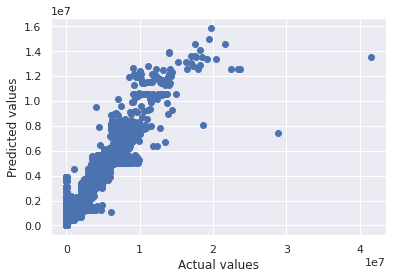

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(numTrees=5, maxDepth=10)
rf.setSeed(108)

model= rf.fit(train)
evaluate(model)

Gradient boosted tree regression

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 75010145240.18265
RMSE = 273879.8007159028
MAE = 100944.99368859903
R2 = 0.9499749527695116
Explained variance = 1592339045507.3323


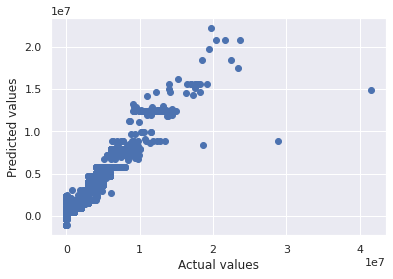

In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", maxIter=10)
model = gbt.fit(train)

evaluate(model)

Dtree

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 69220997291.19855
RMSE = 263098.83559453196
MAE = 99835.08046655817
R2 = 0.954727587979342
Explained variance = 1592338823185.8538


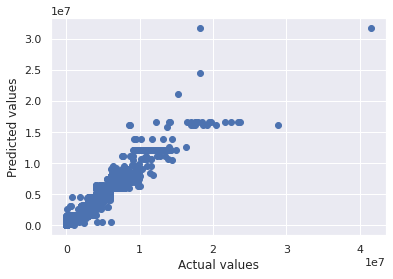

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.mllib.evaluation import RegressionMetrics

dt = DecisionTreeRegressor(maxDepth=10)

model = dt.fit(train)
evaluate(model)